# Финальный проект. Вариант 2

## Задание 1. A/B-тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Самой вероятной целью каких-либо изменений в продукте чаще всего является увеличение выручки. В нашем случае меняется механика оплаты услуг на сайте, т.е. мы предполагаем, что данные изменения могут способствовать увеличению выручки. 
Исходя из предоставленных данных, мы можем использовать для сравнения групп 3 метрики: **CR**(конверсия в покупку), **ARPU**(средний доход с активного пользователя) и **ARPPU**(средний доход с платящего пользователя). 
Если мы используем несколько метрик, то для каждой метрики у нас будут свои гипотезы.

**В случае с CR**:
- *Нулевая гипотеза H0:* Изменения ни к чему не приведут, конверсия останется прежней
- *Альтернативная гипотеза H1:* Изменения приведут к повышению конверсии

**В случае с ARPU**:
- *Нулевая гипотеза H0:* Изменения ни к чему не приведут, ARPU останется прежним
- *Альтернативная гипотеза H1:* Изменения приведут к повышению ARPU

**В случае с ARPPU**:
- *Нулевая гипотеза H0:* Изменения ни к чему не приведут, ARPPU останется прежним
- *Альтернативная гипотеза H1:* Изменения приведут к повышению ARPPU

Соответственно, решение о запуске новой механики оплаты может приниматься, исходя из результата анализа показателей, изначально выбранной для сравнения групп, метрики.

In [1]:
#Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, norm
from tqdm.auto import tqdm
import decimal

In [2]:
# # Загружаем данные
# # Файл с информацией о принадлежности пользователя(А – контроль, B – целевая группа) 
# groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep=';')
# # # Дополнительный файл с пользователями, который мы получили спустя 2 дня после передачи данных
# group_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg')
# # Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
# active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg')
# # Файл с информацией об оплатах пользователей в дни проведения эксперимента
# checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')

In [3]:
# Загружаем данные
# Файл с информацией о принадлежности пользователя(А – контроль, B – целевая группа) 
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-sizova-18/Проект_2_groups.csv', sep=';')
# # Дополнительный файл с пользователями, который мы получили спустя 2 дня после передачи данных
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-sizova-18/Проект_2_group_add.csv')
# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-sizova-18/Проект_2_active_studs.csv')
# Файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-sizova-18/Проект_2_checks.csv', sep=';')

In [4]:
# Просматриваем имеющиеся данные
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [5]:
group_add.head(2)

,id,grp
0,5694584,B
1,5694830,B


In [6]:
active_studs.head(2)

,student_id
0,581585
1,5723133


In [7]:
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [8]:
# Объединяем данные о пользователях и переименовываем колонку id для дальнейшего корректного объединения с остальными данными
all_users = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id':'student_id'}) 

In [9]:
# Проверяем новый датафрейм на наличие дубликатов 
all_users.loc[all_users.duplicated()]

,student_id,grp


In [10]:
# Объединяем данные и получаем датафрейм со всеми пользователями, которые были активны в дни проведения эксперимента, а также 
# датафрейм содержит данные о совершенных оплатах в данный период. Пропущенные значения заменяем на '0'
active = all_users.merge(active_studs, on='student_id').merge(checks, how='left', on='student_id')
active_users = active.fillna(0)
active_users

,student_id,grp,rev
0,1627,A,990.0
1,2085,B,0.0
2,2215,B,0.0
3,3391,A,0.0
4,3401,B,0.0
...,...,...,...
8336,5760471,B,0.0
8337,5777081,B,0.0
8338,5870856,A,0.0
8339,5945085,B,0.0


In [11]:
# active_users['cr'] = active_users['rev'].apply(lambda x: True if x>0 else False)
# active_users

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


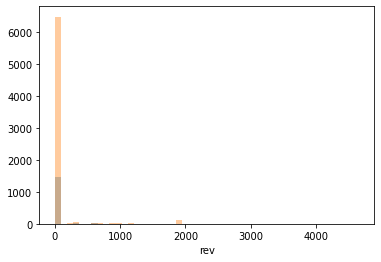

In [12]:
# Построив графики распределения, можно сделать вывод, что распределение признака в обоих группах не соответствует нормальному.
# Как в контрольной, так и в экспериментальной группе мы видим довольно большой процент пользователей, не совершивих покупки
# в дни проведения эксперимента
sns.distplot(active_users[active_users.grp == 'A'].rev, kde=False)
sns.distplot(active_users[active_users.grp == 'B'].rev, kde=False)

**Начнем сравнение с оценки показателя CR в двух группах**

In [13]:
# Группируем данные по принадлежности к контрольной или экспериментальной группе, считаем CR в каждой группе
active_cr = active.groupby('grp',as_index=False).agg({'student_id':'count', 'rev':'count'}).rename(columns={'student_id':'total', 'rev':'paying_users'})
active_cr['CR'] = round((active_cr.paying_users/active_cr.total * 100), 2)
active_cr

,grp,total,paying_users,CR
0,A,1538,78,5.07
1,B,6803,314,4.62


Мы видим снижение CR в экспериментальной группе примерно на 0.45%. Чтобы сделать осмысленный вывод, нам необходимо провести статистический тест для определения значимо ли данное различие. В нашем случае можно использовать Хи-квадрат.

In [14]:
active_cr['not_paying'] = active_cr.total - active_cr.paying_users
data_for_test = active_cr[['paying_users', 'not_paying']]
data_for_test

,paying_users,not_paying
0,78,1460
1,314,6489


In [15]:
data = data_for_test
chi2 = stats.chi2_contingency(data)
print('chi2_statistic=%.3f, p-value=%.3f, df=%i, expected_frep=%s'%chi2)

chi2_statistic=0.485, p-value=0.486, df=1, expected_frep=[[  72.28102146 1465.71897854]
 [ 319.71897854 6483.28102146]]


Согласно результатам, мы получили p-value = 0.486, это превышает уровень ɑ = 0.05, что позволяет нам сделать вывод о том, что статистически значимых различий нет и принять нулевую гипотезу.

**Следующая метрика для сравнения это ARPU за период проведения экспримента** 

In [16]:
arpu = active_users.groupby('grp', as_index=False).agg({'student_id':'count', 'rev':'mean'}).rename(columns={'student_id':'quantity', 'rev':'ARPU'})
arpu

,grp,quantity,ARPU
0,A,1538,47.347204
1,B,6803,58.058798


В случае с ненормальным распределением внутри выборок, наиболее подходящим для сравнения средних в группах будет Bootstrap. Также в нашем случае мы имеем сильно различающиеся по количеству наблюдений группы

In [17]:
# Функция для проведения Bootstrap
def get_bootstrap(data_column_1, data_column_2, boot_it, statistic, bootstrap_conf_level):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

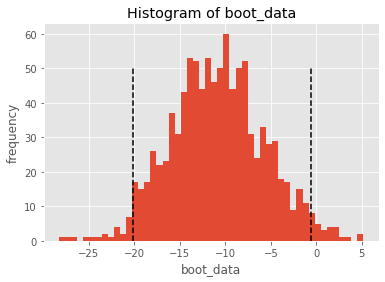

p-value = 0.034043685747618006


,0
0.025,-20.177301
0.975,-0.543033


In [19]:
booted_data = get_bootstrap(active_users[active_users.grp == 'A'].rev, 
                              active_users[active_users.grp == 'B'].rev,
                              boot_it = 1000, 
                              statistic = np.mean, 
                              bootstrap_conf_level = 0.95)
print('p-value =', booted_data["p_value"])
booted_data["ci"]

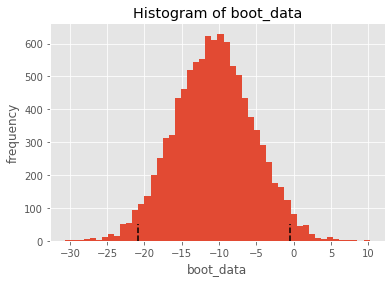

p-value = 0.04137727682349796


,0
0.025,-20.909904
0.975,-0.526404


In [20]:
booted_data = get_bootstrap(active_users[active_users.grp == 'A'].rev, 
                              active_users[active_users.grp == 'B'].rev,
                              boot_it = 10000, 
                              statistic = np.mean, 
                              bootstrap_conf_level = 0.95)
print('p-value =', booted_data["p_value"])
booted_data["ci"]

В данном случае, на разных по размеру выборках мы получаем p-value < 0.05 (0.03 и 0.04), границы доверительного интервала расположены слева от нуля, что также свидетельствует о значимых различиях. Это позволяет нам отклонить нулевую гипотезу и принять альтернативную. Средние значения в экспериментальной группе статистически значимо выше.

**И последняя метрика это ARPPU**

In [21]:
arppu = all_users.merge(active_studs, on='student_id').merge(checks, on='student_id')

In [22]:
arppu.groupby('grp', as_index=False).agg({'student_id':'count', 'rev':'mean'}).rename(columns={'student_id':'quantity', 'rev':'arppu'})

,grp,quantity,arppu
0,A,78,933.589744
1,B,314,1257.878992


В случае с ARPPU сразу можно заметить довольно большие различия. Здесь также применяем Bootstrap на выборках разного размера

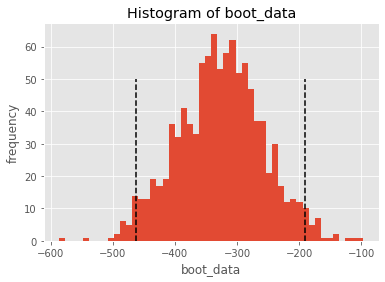

p-value = 0.0000019


,0
0.025,-462.298264
0.975,-190.440773


In [24]:
booted_data = get_bootstrap(arppu[arppu.grp == 'A'].rev, 
                              arppu[arppu.grp == 'B'].rev,
                              boot_it = 1000, 
                              statistic = np.mean, 
                              bootstrap_conf_level = 0.95)
print('p-value =', str(decimal.Decimal(booted_data["p_value"]))[:9])
booted_data["ci"]

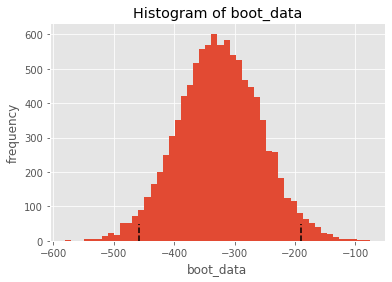

p-value = 0.0000017


,0
0.025,-458.017527
0.975,-190.670550


In [25]:
booted_data = get_bootstrap(arppu[arppu.grp == 'A'].rev, 
                              arppu[arppu.grp == 'B'].rev,
                              boot_it = 10000, 
                              statistic = np.mean, 
                              bootstrap_conf_level = 0.95)
print('p-value =', str(decimal.Decimal(booted_data["p_value"]))[:9])
booted_data["ci"]

p-value на выборках разного размера равно 0.0000019 и 0.0000017, что гораздо меньше ɑ = 0.05, это позволяет нам принять альтернативную гипотезу о разнице средних в исследуемых группах

## Вывод:

Проверив 3 различные гипотезы можно сделать следующие выводы. Мы можем принять решение о запуске новой механики оплаты исходя из гипотезы, которая была выдвинута перед проведением эксперимента:
- Если нашей целью было увеличение конверсии в покупку, и возможной гипотезой было предположение о том, что новая механика оплаты увеличит конверсию в покупку, то исходя из результатов эксперимента, мы отклонили гипотезу о статистически значимых различиях в исследуемых группах. Соответственно, в этом случае, нам не стоит применять новую механику на всех пользователей.

- Если целью было увеличение ARPU, и гипотеза заключалась в том, что новая механика оплаты увеличит среднюю выручку, то эта гипотеза была потдверждена. И мы можем рассмотреть возможность применения новой механики оплаты на всех пользователей. 

- Самая большая разница средних значений наблюдалась в случае с метрикой ARPPU. Что подтвержает гипотезу о том, что изменение приведет к повышению ARPPU. И в это случае мы также можем рассмотреть возможность введения новой механики оплаты.

Интересно то, что новая механика оплаты не повлияла на конверсию, но увеличила выручку с одного пользователя. Можно предположить, что старая механика оплаты не была сдерживающим фактором при решении совершить покупку, и для увеличения конверсии необходимо искать какие-то другие решения.


---

## Задание 2. SQL

### 2.1 Очень усердные ученики

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

In [26]:
# SELECT
#     month,
#     COUNT(st_id) AS number_of_students
# FROM 
#     (SELECT
#         st_id,
#         date_trunc('month', timest) AS month,
#         date_trunc('hour', timest) AS hour,
#         COUNT(correct) AS count_correct
#     FROM peas
#     WHERE correct = '1'
#     GROUP BY st_id, month, hour
#     ) AS sq
# WHERE count_correct >= 20 AND month = '03/01/20 00:00'
# GROUP BY month

### 2.2 Оптимизация воронки

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [27]:
# SELECT 
#     test_grp,
#     SUM(money)/COUNT(DISTINCT st_id) AS ARPU,
#     SUM(money)/COUNT(DISTINCT active) AS ARPAU,
#     COUNT(DISTINCT sale_time)/COUNT(DISTINCT st_id) AS CR,
#     COUNT(DISTINCT sale_time)/COUNT(DISTINCT active) AS CR_active,
#     COUNT(DISTINCT pay_math)/COUNT(DISTINCT trial_math) AS CR_math
# FROM    
#     (
#     SELECT 
#         a.st_id AS st_id,
#         a.timest AS timest,
#         a.subject AS subject_trial,
#         b.test_grp AS test_grp,
#         c.sale_time AS sale_time,
#         c.money AS money,
#         (SELECT COUNT(DISTINCT st_id) FROM peas WHERE correct IS NOT NULL) AS active,
#         (SELECT COUNT(DISTINCT st_id) FROM peas WHERE subject = 'math') AS trial_math,
#         (SELECT COUNT(DISTINCT sale_time) FROM checks WHERE subject = 'math') AS pay_math
#     FROM peas AS a
#         LEFT JOIN studs AS b 
#             ON a.st_id = b.st_id
#         LEFT JOIN checks AS c 
#             ON a.st_id = c.st_id AND a.subject = c.subject
#     ) AS sq1
# GROUP BY test_grp

---

### Задание 3. Python

- **Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики**

In [28]:
def add_new_data(groups, group_add, active_studs, checks):
    # Объединяем таблицы
    all_users = pd.concat([groups, group_add], ignore_index=True).rename(columns={'id':'student_id'})
    active_users = all_users.merge(active_studs, on='student_id').merge(checks, how='left', on='student_id')
    # Меняем пропущенные знаяения на 0
    active = active_users.fillna(0)
    # Считаем CR в группах
    cr = active_users.groupby('grp').agg({'student_id':'count', 'rev':'count'}).rename(columns={'student_id':'total', 'rev':'paying_users'})
    cr['CR'] = round((cr.paying_users/cr.total * 100), 2)
    # Считаем ARPU в группах
    arpu = active.groupby('grp', as_index=False).agg({'student_id':'count', 'rev':'mean'}).rename(columns={'student_id':'quantity', 'rev':'ARPU'})
    # Считаем ARPPU в группах
    arppu = all_users.merge(active_studs, on='student_id').merge(checks, on='student_id')
    arppu = arppu.groupby('grp', as_index=False).agg({'student_id':'count', 'rev':'mean'}).rename(columns={'student_id':'quantity', 'rev':'ARPPU'})
    # Объединяем все метрики в одну таблицу
    all_metrics = cr.merge(arpu, on='grp').merge(arppu, on='grp')
    all_metrics = all_metrics[['grp', 'total', 'paying_users', 'CR', 'ARPU', 'ARPPU']]
    
    return all_metrics

In [29]:
add_new_data(groups, group_add, active_studs, checks)

,grp,total,paying_users,CR,ARPU,ARPPU
0,A,1538,78,5.07,47.347204,933.589744
1,B,6803,314,4.62,58.058798,1257.878992


- **Реализуйте функцию, которая будет строить графики по получаемым метрикам**

In [30]:
def build_a_graph(df1, df2, df3):
    sns.set(rc={'figure.figsize':(7,4)})
    sns.barplot(x="grp", y='CR', data=df1)
    plt.title ("CR")
    plt.xlabel('Group')
    plt.ylabel('CR, %')
    plt.show()
    
    sns.boxplot(x="grp", y="rev", data=df2)
    plt.title ("ARPU")
    plt.xlabel('Group')
    plt.ylabel('Revenue')
    plt.show()
    
    sns.boxplot(x="grp", y="rev", data=df3)
    plt.xlabel('Group')
    plt.ylabel('Revenue')
    plt.title ("ARPPU")
    plt.show()

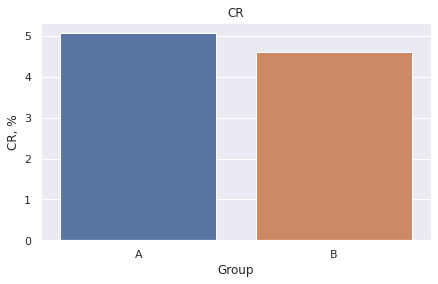

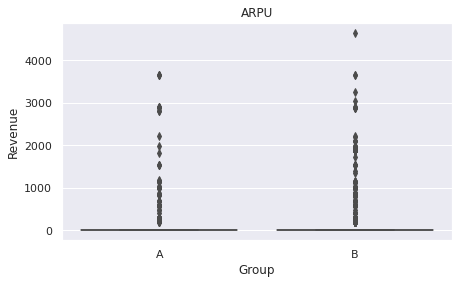

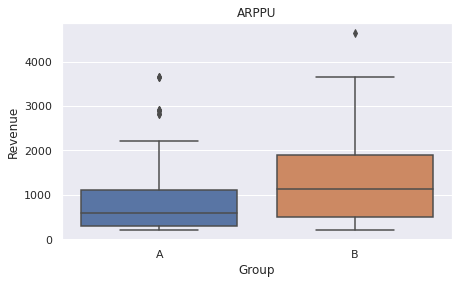

In [31]:
build_a_graph(active_cr, active_users, active)